In [39]:
import numpy as np
import pandas as pd
from datetime import datetime
from collections import Counter
import time
import os.path
import json
import bokeh
from bokeh.plotting import figure, show, output_file
from bokeh.palettes import Category20_20, Category10_10, Dark2_8, Set2_8, Accent8
from bokeh.models import ColumnDataSource, DatetimeTickFormatter, HoverTool
from itertools import cycle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
sns.set()

In [77]:
COLORS = Category20_20[::2] + Category20_20[1::2] + Accent8 + Category20_20[1::2]

In [55]:
class FacebookChat:
    # Only for non group messages
    DELETED_USER = "Deleted User"
    def __init__(self, json):
        self.json = json
        self.participants = json["participants"] + [NAME]
        self.total_messages = len(json["messages"])
        self.messages_sent = 0 # how this is handled is actually shit but im too lazy
        self.total_words = 0
        self.words_sent = 0
        self.total_stickers = 0
        self.stickers_sent = 0
        self.words = {p: {} for p in self.participants}
        
        if "title" not in json:
            self.title = json["thread_path"]
        elif len(self.participants) == 2:
            self.title = self.participants[0]
        else:
            self.title = json["title"]
            
        categories = ["messages", "words", "stickers"]
        self.data = {cat : data for cat, data in zip(categories, self.detailed_breakdown_by_date())}
        
        
    def breakdown_by_date(self, mode):
        '''msgs_by_date is a dict {date : num <mode>}'''
        if mode == "messages":
            return {date: sum(ind_breakdown.values())
                for date, ind_breakdown in self.data["messages"].items()}
        elif mode == "words":
            return {date: sum(ind_breakdown.values())
                for date, ind_breakdown in self.data["words"].items()}
        elif mode == "stickers":
            return {date: sum(ind_breakdown.values())
                for date, ind_breakdown in self.data["stickers"].items()}
    
    def detailed_breakdown_by_date(self):
        '''detailed_breakdown is a nested dictionary {dates : {person : num_messages}}'''
        detailed_breakdown_messages, detailed_breakdown_words, detailed_breakdown_stickers = {}, {}, {}
        words_per_message = {p: (0, 0) for p in self.participants}
        for msg in self.json["messages"]:
            
            date = ms_to_date(msg["timestamp_ms"])
            person = msg["sender_name"] if "sender_name" in msg else FacebookChat.DELETED_USER
            msg_content = msg["content"].split(' ') if 'content' in msg else [] # usually a sticker if no content
            msg_length = len(msg_content)
            self.total_words += msg_length
            
            if person in self.participants:
                for word in msg_content:
                    word = word.lower()
                    person_words = self.words[person]
                    person_words[word] = person_words.get(word, 0) + 1
                    self.words[person] = person_words
                
            
            if "sticker" in msg:
                self.total_stickers += 1
                stk_breakdown = detailed_breakdown_stickers.get(date, {})
                ind_stk = stk_breakdown.get(person, 0)
                stk_breakdown[person] = ind_stk + 1
                detailed_breakdown_stickers[date] = stk_breakdown
                
                if "sender_name" in msg and msg["sender_name"] == NAME:
                    self.stickers_sent += 1
            
            msg_breakdown = detailed_breakdown_messages.get(date, {})
            word_breakdown = detailed_breakdown_words.get(date, {})
            
            # inner dictionary
            ind_msg = msg_breakdown.get(person, 0)
            msg_breakdown[person] = ind_msg + 1
            detailed_breakdown_messages[date] = msg_breakdown
            
            ind_word = word_breakdown.get(person, 0)
            word_breakdown[person] = ind_word + msg_length
            detailed_breakdown_words[date] = word_breakdown
            
            if "sender_name" in msg and msg["sender_name"] == NAME:
                self.messages_sent += 1
                self.words_sent += msg_length
            
    
        return (detailed_breakdown_messages, detailed_breakdown_words, detailed_breakdown_stickers)
    
    def group_breakdown_by_date(self):
        pass
    
    def is_groupchat(self):
        return len(self.participants) > 2
    
    def is_deleted_user(self):
        return not self.is_groupchat() and '' in self.participants
    
    def get_data(self, mode, start_date=None, end_date=None): # Change this so it isnt none
        if mode == "messages":
            return self.data["messages"]
        elif mode == "words":
            return self.data["words"]
        elif mode == "stickers":
            return self.data["stickers"]

def ms_to_date(ms):
    dt = datetime.fromtimestamp(ms//1000)
    return dt.strftime("%Y-%m")
    return "{}/{}".format(dt.month, dt.year) # puts it in M/YYYY format

def gen_total_df(chats, mode):
    all_data = {}
    other_counter = Counter()
    delete_counter = Counter()
    total = 0
    total_sent = 0
    for name, chat in chats.items():
        if chat.is_groupchat() and IGNORE_GROUPCHATS:
            continue
            
        if mode == "messages":
            total += chat.total_messages
            total_sent += chat.messages_sent
        elif mode == "words":
            total += chat.total_words
            total_sent += chat.words_sent
        elif mode == "stickers":
            total += chat.total_stickers
            total_sent += chat.stickers_sent
            
        if chat.is_deleted_user():
            delete_counter += Counter(chat.breakdown_by_date(mode))
        elif chat.total_messages < THRESHOLD:
            other_counter += Counter(chat.breakdown_by_date(mode))
        else:
            all_data[name] = chat.breakdown_by_date(mode)
            
    all_data["Deleted Users"] = dict(delete_counter)
    all_data["others"] = dict(other_counter)
    return all_data, total, total_sent

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

def sum_dict(d):
    return sum([x for x in d.values()])

def conv_to_perc(df):
    return df.divide(df.sum(axis=1), axis="rows")

def stacked(df): # straight from the docs, makes outlines of the glyphs
    df_top = df.cumsum(axis=1)
    df_bottom = df_top.shift(axis=1).fillna(0)
    df_line = (df_top + df_bottom)/2
    df_stack = pd.concat([df_bottom[::-1], df_top], ignore_index=True)
    return df_stack, df_line

def get_groupchats(chats):
    return {k : v for k, v in chats.items() if len(v.participants) > 2}

In [69]:
def area_plot(df, title):
    df = df.reindex(pd.to_datetime(df.index))
    N = len(df)

    areas, lines = stacked(df)
    x2 = np.hstack((df.index[::-1], df.index))
    source_area = ColumnDataSource(dict(
                xs=[x2] * areas.shape[1],
                ys=[areas[c].values for c in areas],
                color=[COLOR_DICT[name] for name in list(df)],
                label=list(df),
                ))
    
#     source_lines = ColumnDataSource(dict(
#                 xs=[lines.index] * lines.shape[1],
#                 ys=[lines[c].values for c in lines],
#                 color=colors,
#                 label=list(df)))
    
    hover = HoverTool(
        tooltips = [
            ("Person", "@label"),
        ],
        point_policy="follow_mouse")

    p = figure(x_axis_type="datetime", plot_width=1280, plot_height=600)
    p.xaxis[0].formatter = DatetimeTickFormatter(months="%b-%Y")
    p.grid.minor_grid_line_color = '#eeeeee'

    p.patches( xs='xs', ys='ys', color='color', name='area', source=source_area)
#     p.multi_line( xs='xs', ys='ys', color='#000000', name='lines', source=source_lines)
    p.add_tools(hover)
    output_file('graphs/{}.html'.format(title), title=title)

    show(p)

# Fill This Out

In [57]:
NAME = "Andrew Xu"
THRESHOLD = 2000 # threshold of messages before someone is considered others
IGNORE_GROUPCHATS = True  # whether to include groupchat in the analysis 

### Read in Data

In [73]:
files = os.listdir("messages")
ignore = [".DS_Store", "stickers_used"]
chats = {}

for file in files:
    if file in ignore:
        continue
    with open("messages/{}/message.json".format(file), "rb") as f:
        data_json = json.load(f)
    if not "participants" in data_json:# or '' in data_json["participants"]:
        continue

    chat = FacebookChat(data_json)
    chats[chat.title] = chat

#### Set colors

In [79]:
all_data, total_msgs, total_msgs_sent = gen_total_df(chats, "messages")
df_msg = pd.DataFrame(all_data)
df_msg = df_msg.fillna(0)
all_word_data, total_words, total_words_sent = gen_total_df(chats, "words")
df_word = pd.DataFrame(all_word_data)
df_word = df_word.fillna(0)
all_sticker_data, total_stickers, total_stickers_sent = gen_total_df(chats, "stickers")
df_sticker = pd.DataFrame(all_sticker_data)
df_sticker = df_sticker.fillna(0)

colors = [x for _, x in zip(range(len(list(df_msg))), cycle(COLORS))]
COLOR_DICT = {name: color for name, color in zip(df_msg.sum().sort_values().index[::-1], colors)}

## Go one at a time please for the next 3 (Interactive graphs)

In [80]:
area_plot(df_msg, "Messages")
area_plot(conv_to_perc(df_msg), "Messages_Percentage")
time.sleep(10)

In [47]:
area_plot(df_word, "Words")
area_plot(conv_to_perc(df_word), "Words_Percentage")
time.sleep(10)

In [24]:
area_plot(df_sticker, "Stickers")
area_plot(conv_to_perc(df_sticker), "Stickers_Percentage")
time.sleep(10)

# Misc Stats

In [50]:
# See who you message the most
x = df_word.sum().sort_values()

Index(['Deleted Users', 'William Zhao', 'Joan Hsu', 'Joshua Kang',
       'Isaac Chan', 'Andrew Savage', 'Jingjing Zhang', 'Sylvia Bi',
       'Joseph Mink Kwon', 'Jacob Holesinger', 'Jerry Zhao', 'James Ding',
       'Tatiana Su', 'Jasmine Norng', 'Daniel A. Wang', 'Varsha Venkat',
       'Megan Lee', 'Thomas Chow', 'Kevin Chu', 'Sudeep Dasari',
       'Yanis Ait Kaci Azzou', 'Billy Zhao', 'Yuna Shin', 'Yani Mai',
       'Kathy Chen', 'Catherine Xu', 'Timothy Lee', 'Keiran Paster',
       'Mulan Jane Xia', 'Sasha Itkis', 'Forest Yang', 'others',
       'Zermina Wadood', 'Jane Lee', 'Serena Jiang'],
      dtype='object')

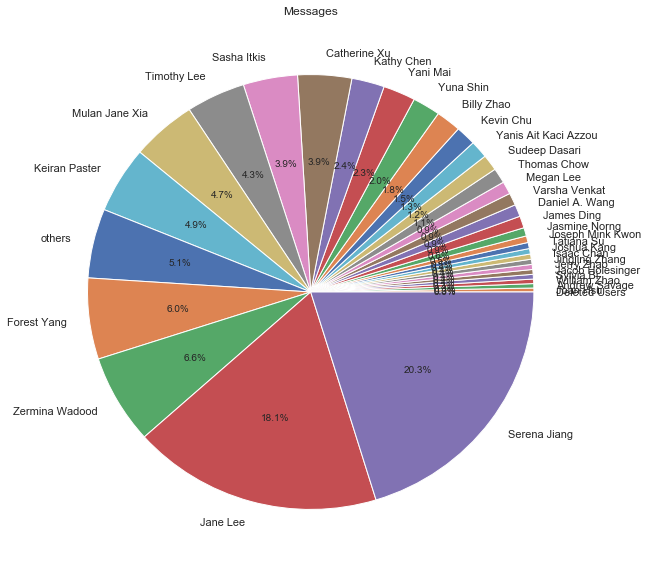

In [20]:
labels = list(df_msg.sum().sort_values().keys())
msgs = [x for x in list(df_msg.sum().sort_values().values)]
plt.figure(figsize=(10,10))
plt.title("Messages")
plt.pie(msgs, labels=labels, autopct="%.1f%%")
plt.show()

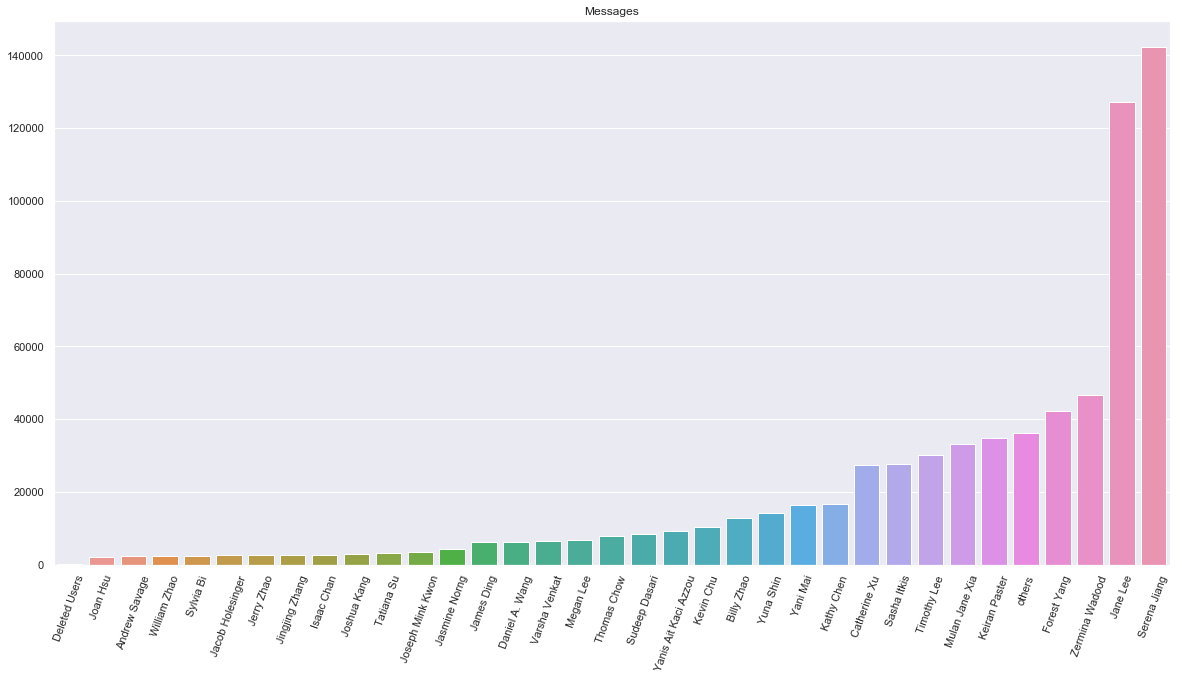

In [21]:
plt.figure(figsize=(20,10))
sns.barplot(x=df_msg.sum().sort_values().keys(), y=df_msg.sum().sort_values().values)
plt.xticks(rotation=70)
plt.title("Messages")
plt.show()


In [25]:
print(df_word.sum().sort_values())

Deleted Users              160.0
William Zhao              8936.0
Joan Hsu                 10691.0
Joshua Kang              10750.0
Isaac Chan               11790.0
Andrew Savage            12111.0
Jingjing Zhang           12168.0
Sylvia Bi                12641.0
Joseph Mink Kwon         12758.0
Jacob Holesinger         13320.0
Jerry Zhao               13719.0
James Ding               16400.0
Tatiana Su               17265.0
Jasmine Norng            17328.0
Daniel A. Wang           25743.0
Varsha Venkat            27025.0
Megan Lee                28400.0
Thomas Chow              30764.0
Kevin Chu                33637.0
Sudeep Dasari            36651.0
Yanis Ait Kaci Azzou     41625.0
Billy Zhao               54757.0
Yuna Shin                62854.0
Yani Mai                 67663.0
Kathy Chen               94432.0
Catherine Xu            108959.0
Timothy Lee             118103.0
Keiran Paster           130084.0
Mulan Jane Xia          134842.0
Sasha Itkis             142858.0
Forest Yan

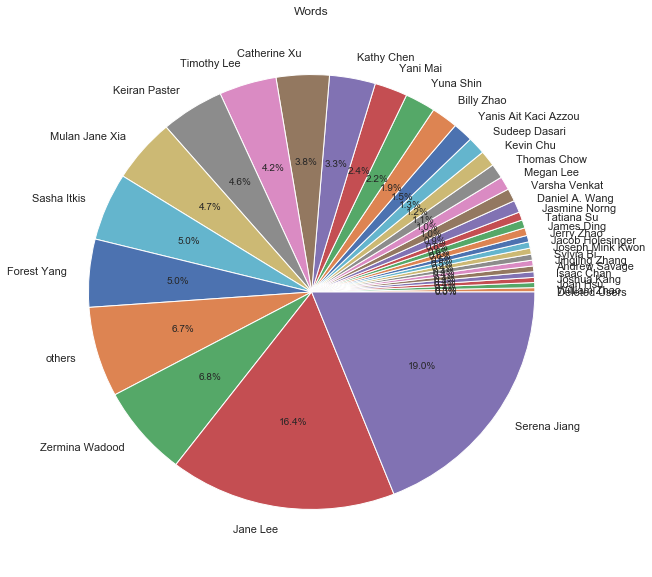

In [26]:
labels = list(df_word.sum().sort_values().keys())
perc = [x for x in list(df_word.sum().sort_values().values)]
plt.figure(figsize=(10,10))
plt.title("Words")
plt.pie(perc, labels=labels, autopct='%.1f%%')
plt.show()

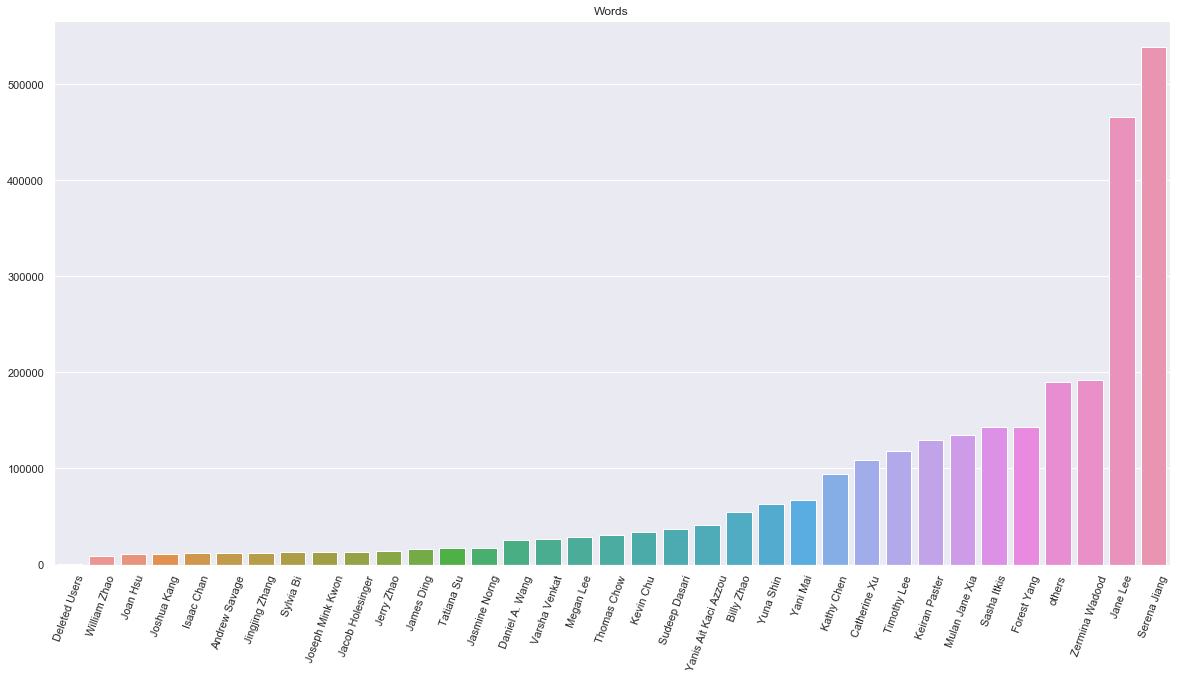

In [27]:
plt.figure(figsize=(20,10))
sns.barplot(x=df_word.sum().sort_values().keys(), y=df_word.sum().sort_values().values)
plt.xticks(rotation=70)
plt.title("Words")
plt.show()


In [28]:
# Average message length
(df_word.sum()/df_msg.sum()).sort_values()

James Ding              2.628626
Kevin Chu               3.273037
Forest Yang             3.386839
Jane Lee                3.663832
Joseph Mink Kwon        3.681962
Keiran Paster           3.751629
Serena Jiang            3.786672
Joshua Kang             3.793225
William Zhao            3.835193
Thomas Chow             3.917484
Timothy Lee             3.928778
Jasmine Norng           3.970669
Catherine Xu            3.976025
Mulan Jane Xia          4.067509
Daniel A. Wang          4.070040
Yani Mai                4.115254
Zermina Wadood          4.124062
Varsha Venkat           4.200995
Megan Lee               4.275821
Billy Zhao              4.293320
Isaac Chan              4.336153
Sudeep Dasari           4.372063
Yuna Shin               4.444177
Jingjing Zhang          4.525102
Yanis Ait Kaci Azzou    4.563644
Deleted Users           4.848485
Sylvia Bi               5.138618
Sasha Itkis             5.164600
Jerry Zhao              5.178935
others                  5.265658
Joan Hsu  

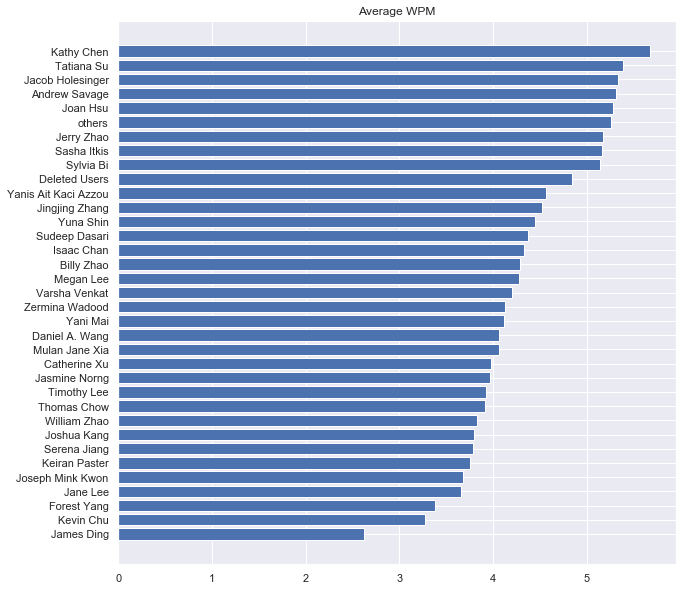

In [29]:
y_pos = np.arange(len(list(df_word)))
plt.figure(figsize=(10,10))
values = (df_word.sum()/df_msg.sum()).sort_values().values
labels = (df_word.sum()/df_msg.sum()).sort_values().keys()
plt.barh(y_pos, values)
plt.yticks(y_pos, labels)
plt.title("Average WPM")
# plt.set_ytickslabels(labels)
plt.show()

In [30]:
print(df_sticker.sum().sort_values())

Deleted Users              0.0
Joshua Kang                0.0
Andrew Savage              1.0
James Ding                 1.0
Sylvia Bi                  1.0
Joseph Mink Kwon           2.0
Isaac Chan                 4.0
Tatiana Su                 8.0
Jingjing Zhang             8.0
Jacob Holesinger          12.0
Kevin Chu                 16.0
Thomas Chow               18.0
William Zhao              20.0
Zermina Wadood            24.0
Kathy Chen                25.0
Varsha Venkat             35.0
Jerry Zhao                36.0
Daniel A. Wang            40.0
Timothy Lee               40.0
Joan Hsu                  47.0
Billy Zhao                54.0
Jasmine Norng             60.0
Yanis Ait Kaci Azzou      70.0
Sudeep Dasari             76.0
Sasha Itkis               84.0
Yani Mai                  96.0
Megan Lee                105.0
Forest Yang              169.0
others                   178.0
Catherine Xu             202.0
Keiran Paster            279.0
Mulan Jane Xia           333.0
Yuna Shi

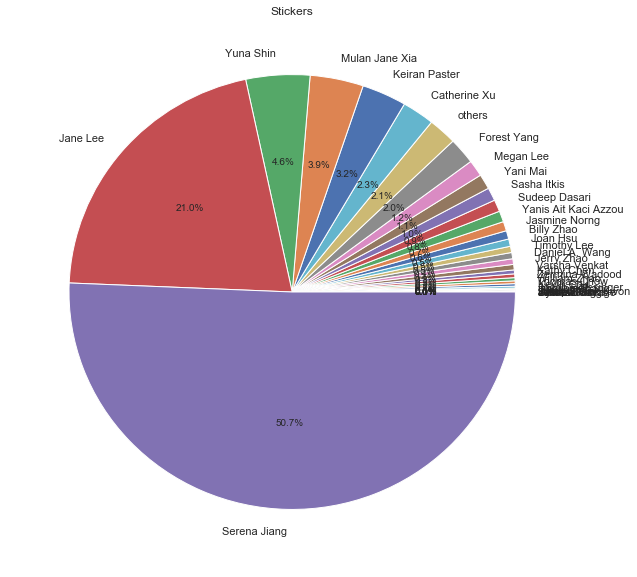

In [31]:
labels = list(df_sticker.sum().sort_values().keys())
perc = [x for x in list(df_sticker.sum().sort_values().values)]
plt.figure(figsize=(10,10))
plt.title("Stickers")
plt.pie(perc, labels=labels, autopct='%.1f%%')
plt.show()

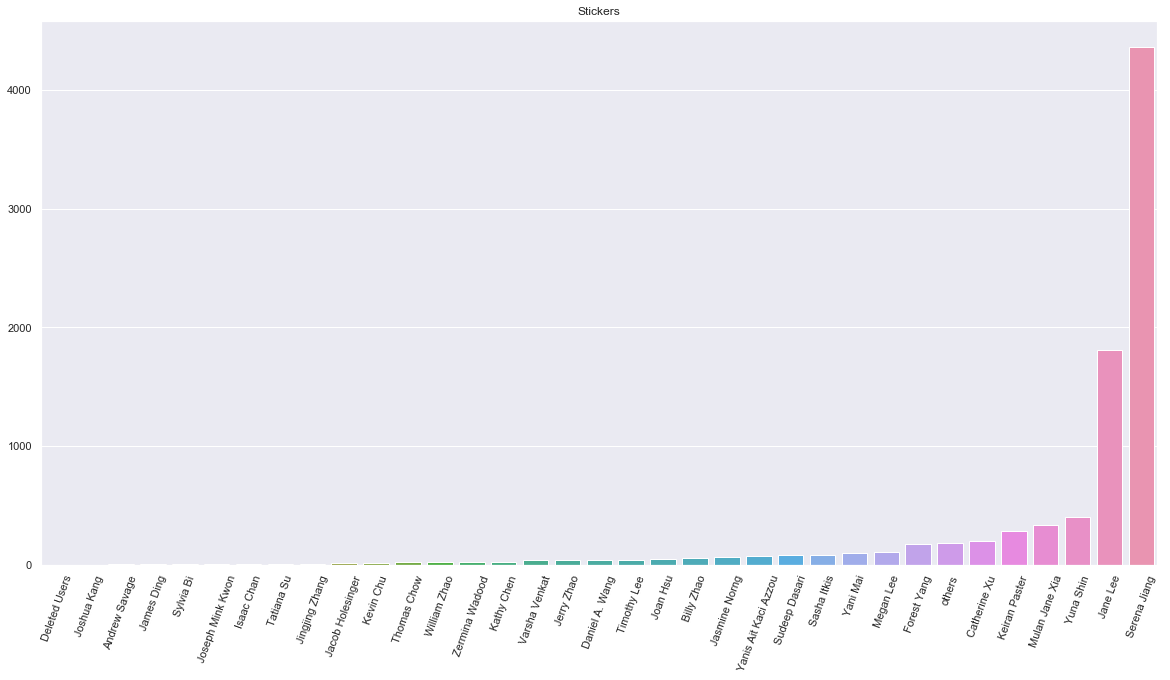

In [32]:
plt.figure(figsize=(20,10))
sns.barplot(x=df_sticker.sum().sort_values().keys(), y=df_sticker.sum().sort_values().values)
plt.xticks(rotation=70)
plt.title("Stickers")
plt.show()

In [33]:
(df_msg.sum()/df_sticker.sum()).sort_values()

Serena Jiang              32.609253
Yuna Shin                 35.446115
Joan Hsu                  43.042553
Megan Lee                 63.257143
Jane Lee                  70.335544
Jasmine Norng             72.733333
Jerry Zhao                73.583333
Mulan Jane Xia            99.552553
Sudeep Dasari            110.302632
William Zhao             116.500000
Keiran Paster            124.279570
Yanis Ait Kaci Azzou     130.300000
Catherine Xu             135.663366
Daniel A. Wang           158.125000
Yani Mai                 171.270833
Varsha Venkat            183.800000
others                   203.162921
Jacob Holesinger         208.166667
Billy Zhao               236.185185
Forest Yang              250.337278
Sasha Itkis              329.297619
Jingjing Zhang           336.125000
Tatiana Su               400.250000
Thomas Chow              436.277778
Kevin Chu                642.312500
Kathy Chen               665.840000
Isaac Chan               679.750000
Timothy Lee              751

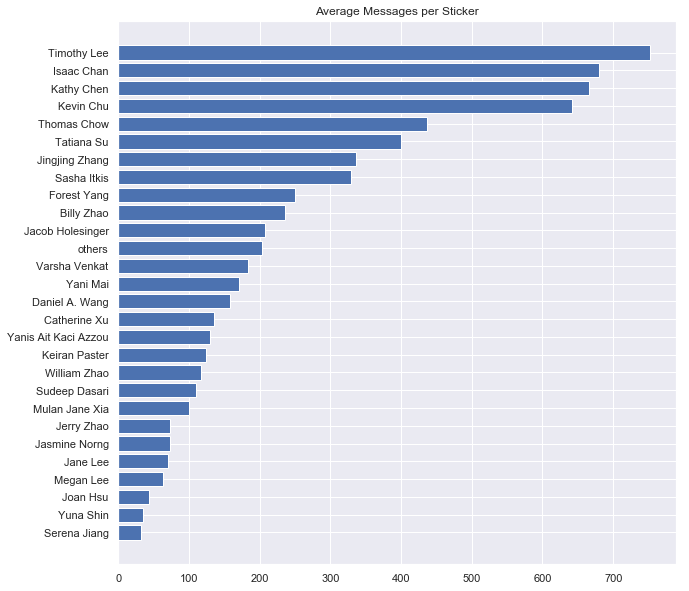

In [34]:

plt.figure(figsize=(10,10))
values = (df_msg.sum()/df_sticker.sum()).sort_values().values
labels = (df_msg.sum()/df_sticker.sum()).sort_values().keys()
new_values, new_labels = [], []
for value, label in zip(values, labels):
    if value < 1000:
        new_values.append(value)
        new_labels.append(label)
y_pos = np.arange(len(list(new_values)))
plt.barh(y_pos, new_values)
plt.yticks(y_pos, new_labels)
plt.title("Average Messages per Sticker")
# plt.set_ytickslabels(labels)
plt.show()

total messages: 702368
total words: 2839339


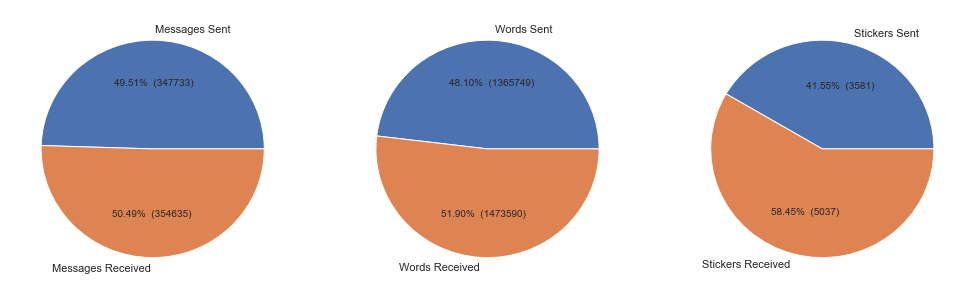

In [35]:
print("total messages: {}".format(total_msgs))
print("total words: {}".format(total_words))


fig, axes = plt.subplots(1,3, figsize=(17,5))
labels = ["Messages Sent", "Messages Received", "Words Sent", "Words Received", "Stickers Sent", "Stickers Received"]
msg_vals = [total_msgs_sent, total_msgs - total_msgs_sent]
axes[0].pie(msg_vals , labels=labels[:2], autopct=make_autopct(msg_vals))
word_vals = [total_words_sent, total_words - total_words_sent]
axes[1].pie(word_vals , labels=labels[2:4], autopct=make_autopct(word_vals))
sticker_vals = [total_stickers_sent, total_stickers - total_stickers_sent]
axes[2].pie(sticker_vals , labels=labels[4:], autopct=make_autopct(sticker_vals))
plt.show()

# Individual Analysis

### Name of other person

In [76]:
OTHER = "Billy Zhao"

In [77]:
OTHER_MSG = OTHER + " messages"
OTHER_WORD = OTHER + " words"
OTHER_STK = OTHER + " stickers"
OTHER_WPM = OTHER + " wpm"
OTHER_MPS = OTHER + " mps"

NAME_MSG = NAME + " messages"
NAME_WORD = NAME + " words"
NAME_STK = NAME + " stickers"
NAME_WPM = NAME + " wpm"
NAME_MPS = NAME + " mps"

In [78]:
chat = chats[OTHER]

data_msg = chat.get_data("messages")
df_ind_msg = pd.DataFrame(data_msg).transpose()
df_ind_msg.rename(index=str, columns={NAME: NAME_MSG, OTHER: OTHER_MSG}, inplace=True)

data_word = chat.get_data("words")
df_ind_word = pd.DataFrame(data_word).transpose()
df_ind_word.rename(index=str, columns={NAME: NAME_WORD, OTHER: OTHER_WORD}, inplace=True)

data_sticker = chat.get_data("stickers")
df_ind_sticker = pd.DataFrame(data_sticker).transpose()
df_ind_sticker = df_ind_sticker.reindex(df_ind_word.index)
df_ind_sticker.fillna(0, inplace=True)
df_ind_sticker.rename(index=str, columns={NAME: NAME_STK, OTHER: OTHER_STK}, inplace=True)

df_ind = pd.concat([df_ind_msg, df_ind_word, df_ind_sticker], axis=1)
df_ind[NAME_WPM] = df_ind[NAME_WORD]/df_ind[NAME_MSG]
df_ind[OTHER_WPM] = df_ind[OTHER_WORD]/df_ind[NAME_MSG]
df_ind[NAME_MPS] = df_ind[NAME_MSG]/df_ind[NAME_STK]
df_ind[OTHER_MPS] = df_ind[OTHER_MSG]/df_ind[OTHER_STK]

df_ind.replace([np.inf, np.NaN], 0, inplace=True)

df_ind = df_ind[::-1]

In [79]:
table = np.zeros((len(chat.participants)*2, 199)).astype(str)
for i, person in enumerate(chat.words):
    table[2*i:2*(i+1)] = np.array(list(zip(*sorted(chat.words[person].items(), key=lambda p: p[1])[:-200:-1])))

In [42]:
df_ind.sum().astype(int)


Andrew Xu messages        71543
Serena Jiang messages     70829
Andrew Xu words          258908
Serena Jiang words       280208
Andrew Xu stickers         2252
Serena Jiang stickers      2114
Andrew Xu wpm               157
Serena Jiang wpm            154
Andrew Xu mps              3311
Serena Jiang mps           6140
dtype: int64

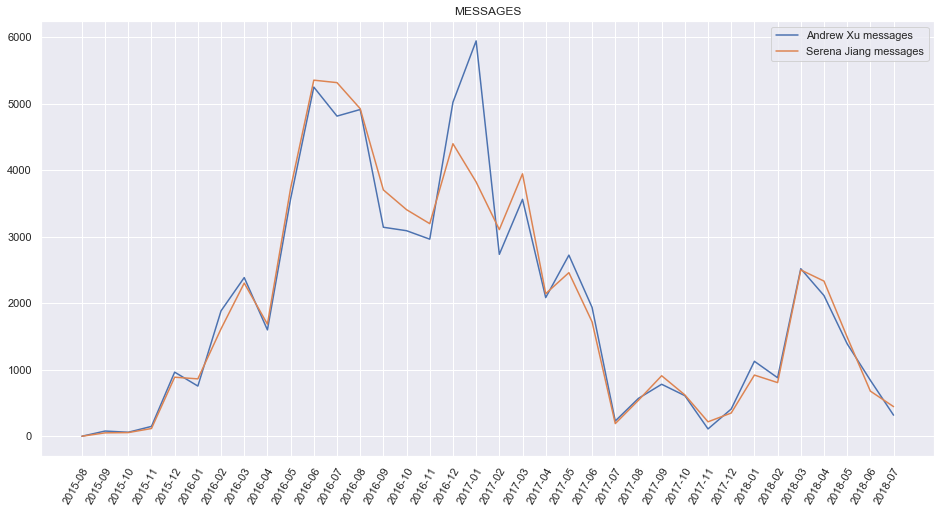

In [43]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(df_ind[NAME_MSG], label=NAME_MSG)
ax.plot(df_ind[OTHER_MSG], label=OTHER_MSG)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor")
plt.title("MESSAGES")
ax.legend()
plt.show()

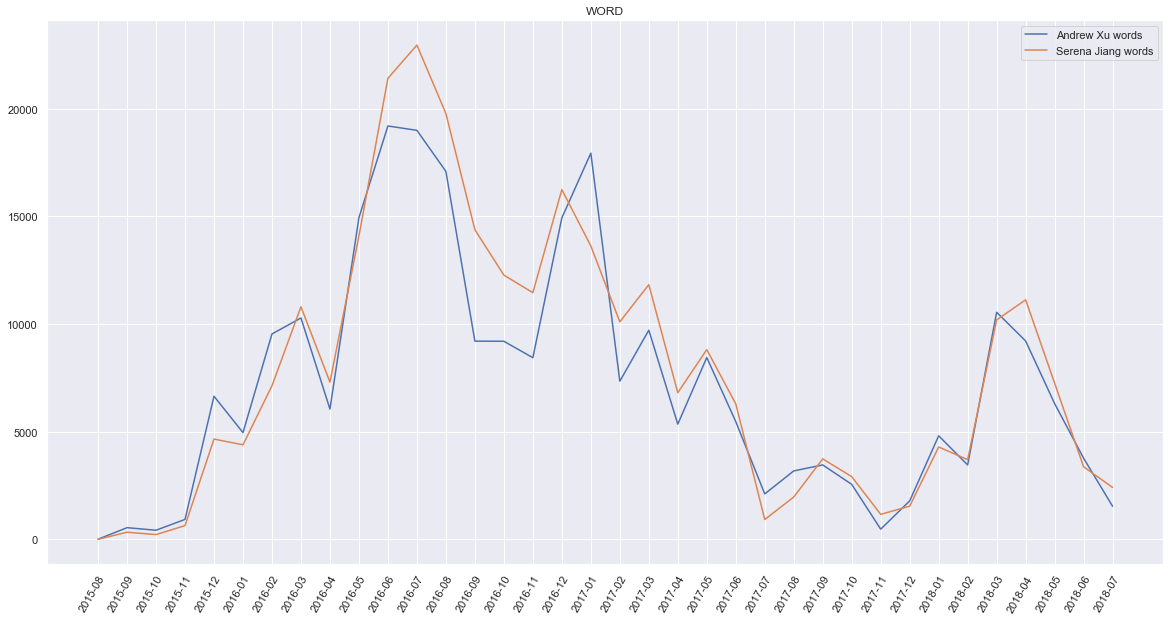

In [44]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_ind[NAME_WORD], label=NAME_WORD)
ax.plot(df_ind[OTHER_WORD], label=OTHER_WORD)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor")
plt.title("WORD")
ax.legend()
plt.show()

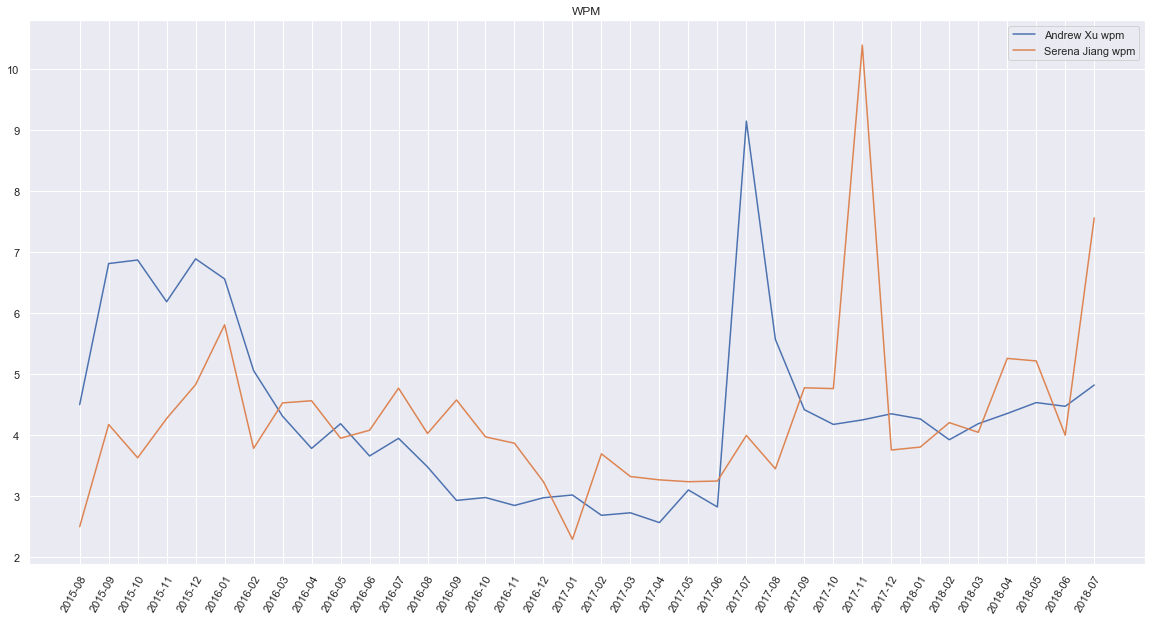

In [45]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_ind[NAME_WPM], label=NAME_WPM)
ax.plot(df_ind[OTHER_WPM], label=OTHER_WPM)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor")
plt.title("WPM")
ax.legend()
plt.show()

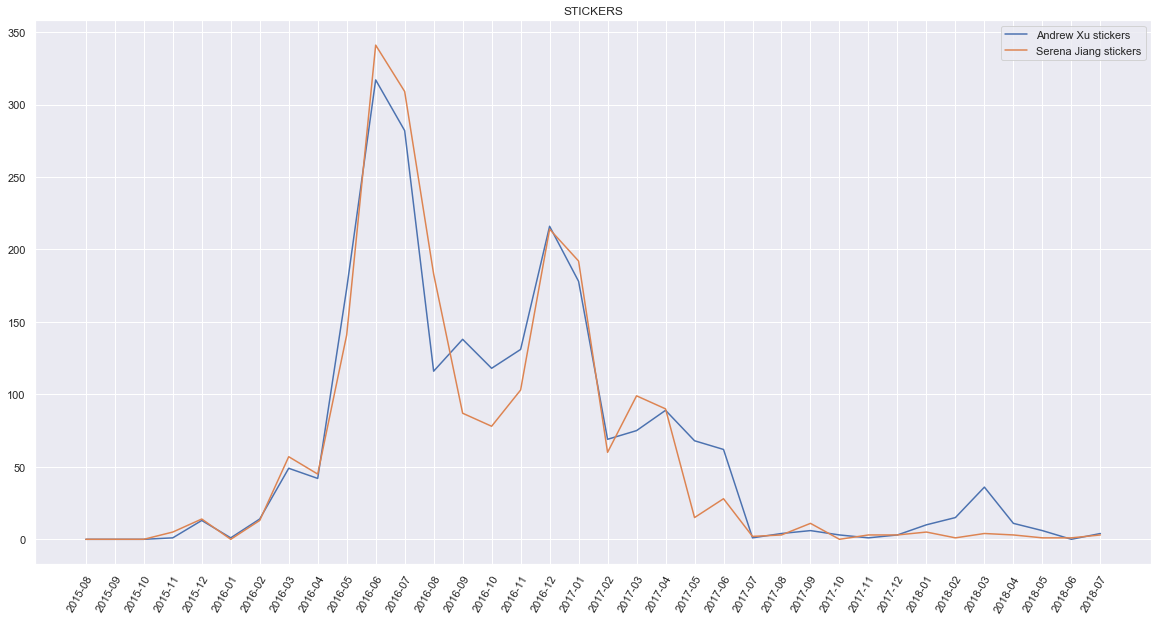

In [46]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_ind[NAME_STK], label=NAME_STK)
ax.plot(df_ind[OTHER_STK], label=OTHER_STK)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor")
plt.title("STICKERS")
ax.legend()
plt.show()

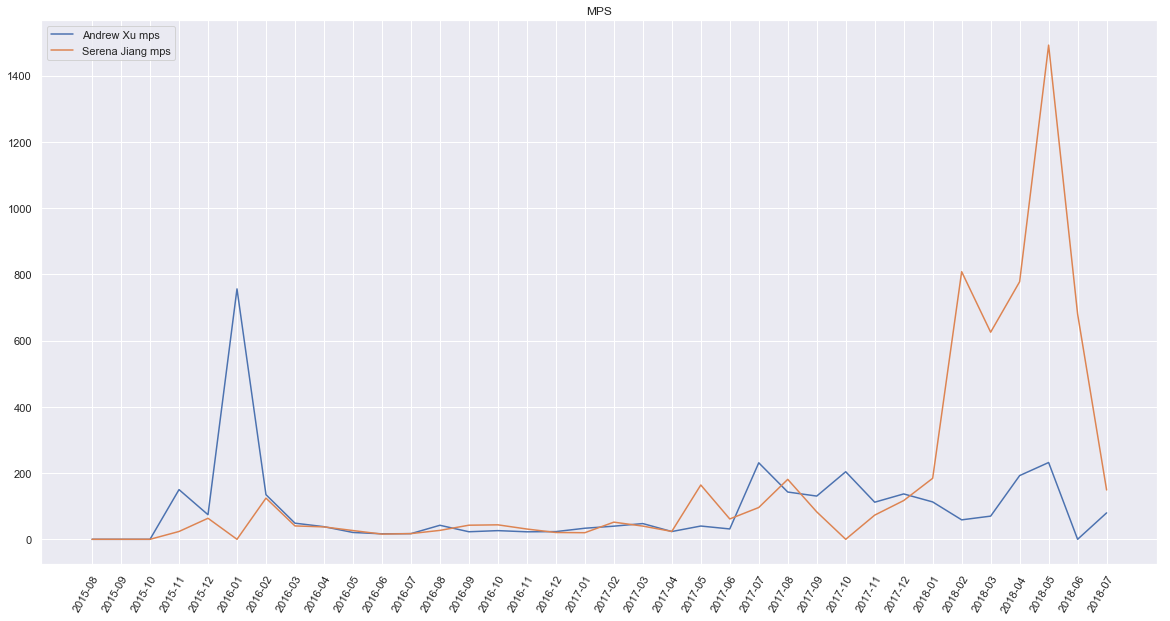

In [47]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_ind[NAME_MPS], label=NAME_MPS)
ax.plot(df_ind[OTHER_MPS], label=OTHER_MPS)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor")
plt.title("MPS")
ax.legend()
plt.show()

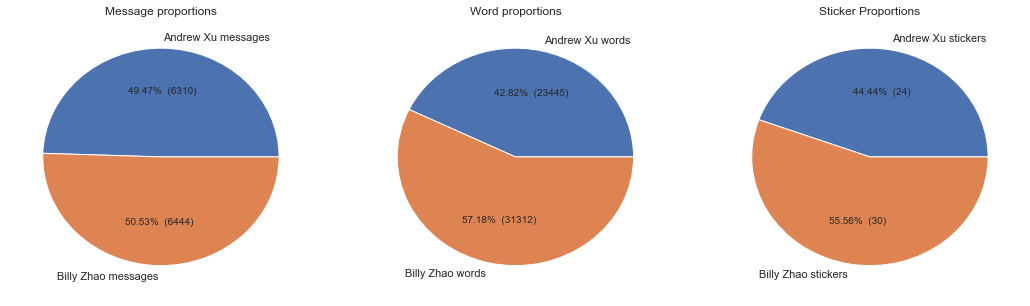

In [81]:
labels = list(df_ind)[:6]

fig, axes = plt.subplots(1,3, figsize=(18,5))

msg_vals = [chat.messages_sent, chat.total_messages - chat.messages_sent]
axes[0].pie(msg_vals, labels=labels[:2], autopct=make_autopct(msg_vals))
axes[0].set_title("Message proportions")

word_vals = [chat.words_sent, chat.total_words - chat.words_sent]
axes[1].pie(word_vals, labels=labels[2:4], autopct=make_autopct(word_vals))
axes[1].set_title("Word proportions")

stk_vals = [chat.stickers_sent, chat.total_stickers - chat.stickers_sent]
axes[2].pie(stk_vals, labels=labels[4:6], autopct=make_autopct(stk_vals))
axes[2].set_title("Sticker Proportions")
plt.show()

In [80]:
pd.set_option('display.max_rows', None)
columns = ""
for i, person in enumerate(chat.participants):
    columns += person + ",freq{},".format(i)
columns = columns[:-1].split(",")
display(pd.DataFrame(table.T, columns=columns))

,Billy Zhao,freq0,Andrew Xu,freq1
0,the,1078,i,855
1,i,1030,to,472
2,,790,the,459
3,you,754,you,348
4,to,729,it,313
5,a,437,ok,284
6,and,434,like,282
7,is,385,and,280
8,it,372,a,276
9,for,308,is,272


## Groupchats

In [49]:
groupchats = get_groupchats(chats)

In [50]:
sorted([(k, v.total_messages) for k, v in groupchats.items() if v.total_messages > 1000], key=lambda x: x[1])

[('friendship obligations', 1087),
 ('ð\x9f\x8f\x8bï¸\x8fâ\x80\x8dâ\x99\x80ï¸\x8f squad', 1143),
 ('Delicious cell', 1189),
 ('dtf', 1402),
 ('bears', 1420),
 ('wizards 170', 1429),
 ('Fat Chick', 1457),
 ('friendship obligations part 2', 1664),
 ('Forest, Jonathan and Kevin', 1741),
 ('G4', 2240),
 ('Cs70!!', 2332),
 ('R-Side Gang Gang', 2335),
 ('I Peaked In High School', 2503),
 ('Greed is good', 2822),
 ('run', 2992),
 ('1.8.9.', 2996),
 ('DarkVR', 3175),
 ('north >>> king', 4598),
 ('Housemates', 4836),
 ("Sudeep's abusive relationships", 25130),
 ("Vi's Graduation Harem", 49357)]

In [51]:
GROUPCHAT_NAME = "Vi's Graduation Harem"

In [52]:
chat = chats[GROUPCHAT_NAME]

## Run through these run at a time please (Interactive graphs)

In [54]:
df_groupchat_msg = pd.DataFrame(chat.get_data("messages")).transpose().fillna(0)[::-1]
area_plot(df_groupchat_msg, "Groupchat messages")
area_plot(conv_to_perc(df_groupchat_msg), "Groupchat msg percentage")
time.sleep(10) # SLEEP TO ALLOW GRAPHS TO LOAD

In [58]:
df_groupchat_word= pd.DataFrame(chat.get_data("words")).transpose().fillna(0)[::-1]
area_plot(df_groupchat_word, "Groupchat words")
area_plot(conv_to_perc(df_groupchat_word), "Groupchat word percentage")
time.sleep(10)

In [59]:
df_groupchat_stk = pd.DataFrame(chat.get_data("stickers")).transpose().fillna(0)[::-1]
area_plot(df_groupchat_stk, "Groupchat stickers")
area_plot(conv_to_perc(df_groupchat_stk), "Groupchat sticker percentage")
time.sleep(10)

## Inline graphs

In [60]:
df_groupchat_msg.sum().sort_values()

Ben Duan               1.0
Henk Tillman          14.0
Vi Le                203.0
Aiswarya Sankar      428.0
Andrew Dong         1609.0
Keiran Paster       1648.0
Lakshya Jain        1990.0
Billy Zhao          2223.0
Jacob Holesinger    2941.0
Megan Lee           3680.0
Sudeep Dasari       3915.0
Serena Jiang        5287.0
Andrew Xu           5337.0
William Zhao        5374.0
Daniel A. Wang      6273.0
Varsha Venkat       8434.0
dtype: float64

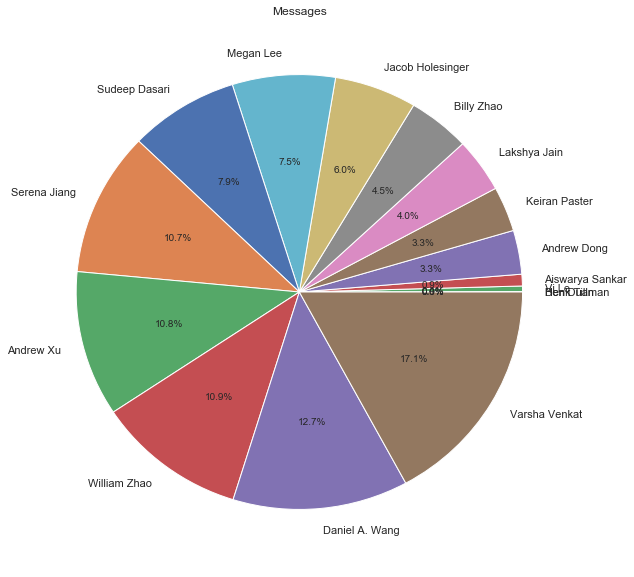

In [61]:
labels = list(df_groupchat_msg.sum().sort_values().keys())
msgs = [x for x in list(df_groupchat_msg.sum().sort_values().values)]
plt.figure(figsize=(10,10))
plt.title("Messages")
# plt.pie(xd, labels=labels, autopct=make_autopct(xd))
plt.pie(msgs, labels=labels, autopct="%.1f%%")
plt.show()

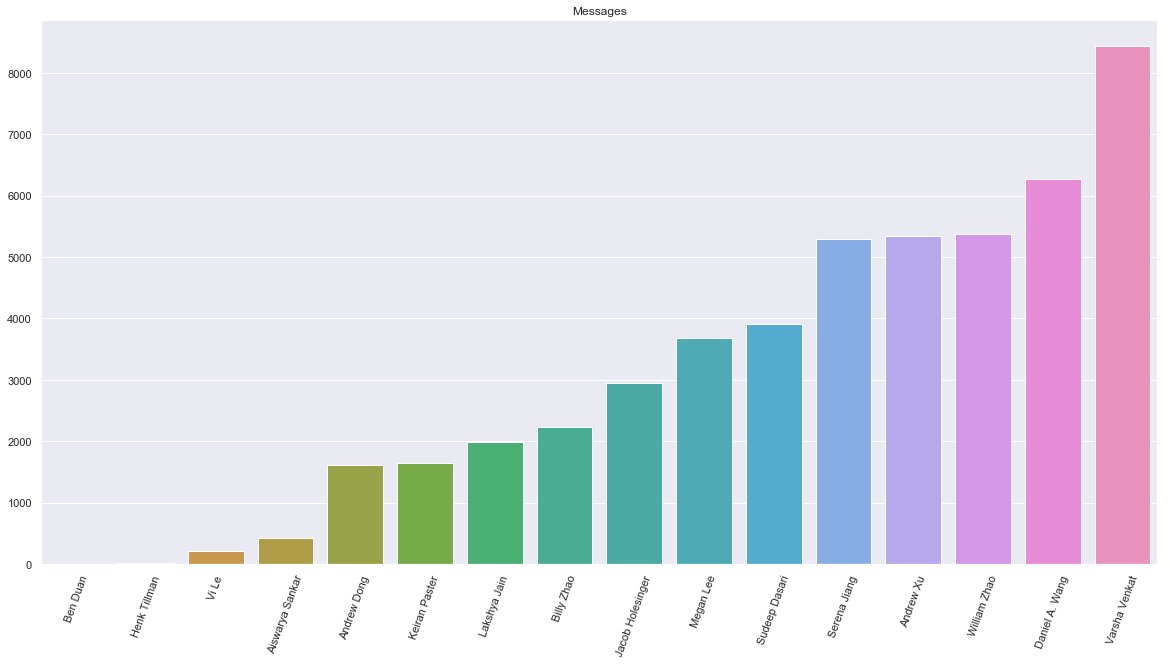

In [62]:
plt.figure(figsize=(20,10))
sns.barplot(x=df_groupchat_msg.sum().sort_values().keys(), y=df_groupchat_msg.sum().sort_values().values)
plt.xticks(rotation=70)
plt.title("Messages")
plt.show()


In [63]:
df_groupchat_word.sum().sort_values()

Ben Duan                1.0
Henk Tillman           54.0
Vi Le                1182.0
Aiswarya Sankar      2045.0
Keiran Paster        6769.0
Andrew Dong          7586.0
Billy Zhao          12232.0
Lakshya Jain        12698.0
Megan Lee           14054.0
Jacob Holesinger    17945.0
Sudeep Dasari       21566.0
Andrew Xu           21846.0
William Zhao        22214.0
Serena Jiang        22774.0
Daniel A. Wang      30627.0
Varsha Venkat       40026.0
dtype: float64

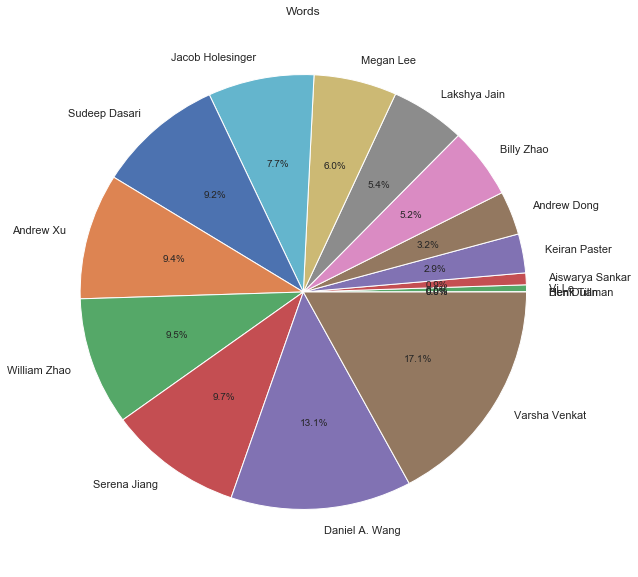

In [64]:
labels = list(df_groupchat_word.sum().sort_values().keys())
msgs = [x for x in list(df_groupchat_word.sum().sort_values().values)]
plt.figure(figsize=(10,10))
plt.title("Words")
# plt.pie(xd, labels=labels, autopct=make_autopct(xd))
plt.pie(msgs, labels=labels, autopct="%.1f%%")
plt.show()

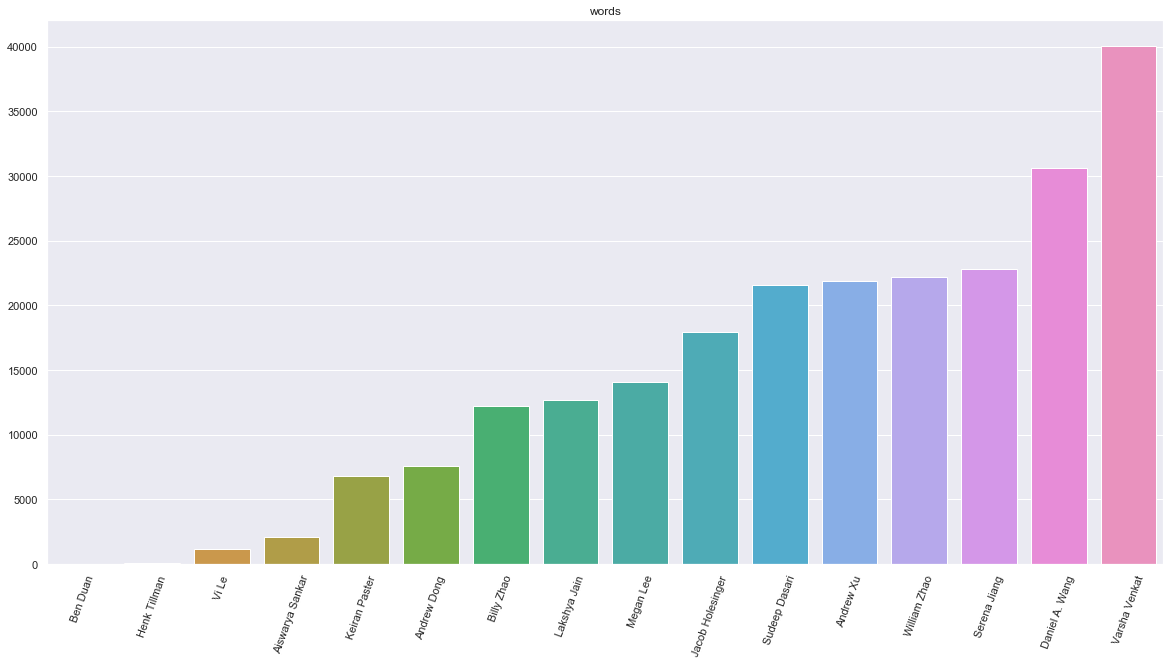

In [65]:
plt.figure(figsize=(20,10))
sns.barplot(x=df_groupchat_word.sum().sort_values().keys(), y=df_groupchat_word.sum().sort_values().values)
plt.xticks(rotation=70)
plt.title("words")
plt.show()


In [66]:
(df_groupchat_word.sum()/df_groupchat_msg.sum()).sort_values()

Ben Duan            1.000000
Megan Lee           3.819022
Henk Tillman        3.857143
Andrew Xu           4.093311
Keiran Paster       4.107403
William Zhao        4.133606
Serena Jiang        4.307547
Andrew Dong         4.714730
Varsha Venkat       4.745791
Aiswarya Sankar     4.778037
Daniel A. Wang      4.882353
Billy Zhao          5.502474
Sudeep Dasari       5.508557
Vi Le               5.822660
Jacob Holesinger    6.101666
Lakshya Jain        6.380905
dtype: float64

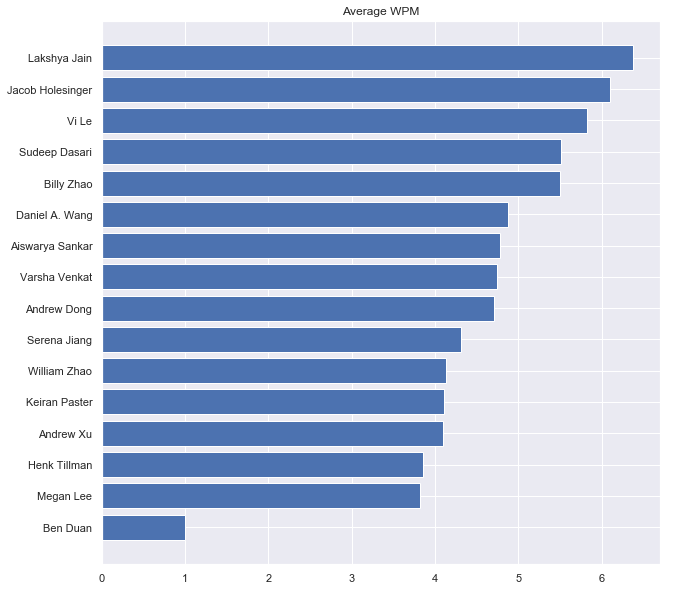

In [67]:
y_pos = np.arange(len(list(df_groupchat_word)))
plt.figure(figsize=(10,10))
values = (df_groupchat_word.sum()/df_groupchat_msg.sum()).sort_values().values
labels = (df_groupchat_word.sum()/df_groupchat_msg.sum()).sort_values().keys()
plt.barh(y_pos, values)
plt.yticks(y_pos, labels)
plt.title("Average WPM")
# plt.set_ytickslabels(labels)
plt.show()

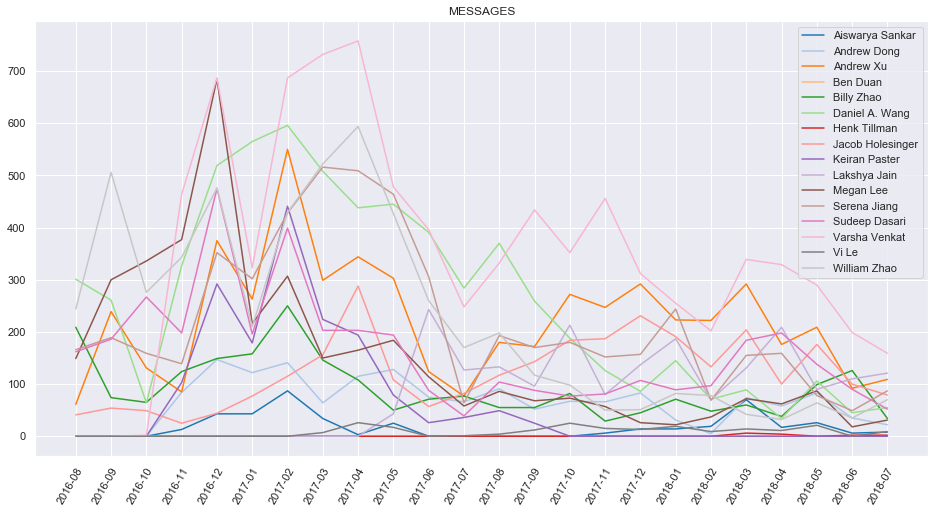

In [68]:
fig, ax = plt.subplots(figsize=(16,8))
colors = [c for c, _ in zip(cycle(Category20_20), range(len(df_groupchat_msg)))]
for i, person in enumerate(df_groupchat_msg):
    ax.plot(df_groupchat_msg[person], label=person, color=colors[i])
# ax.plot(df_ind[NAME_MSG], label=NAME_MSG)
# ax.plot(df_ind[OTHER_MSG], label=OTHER_MSG)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor")
plt.title("MESSAGES")
ax.legend()
plt.show()

In [69]:
df_groupchat_msg.astype(int)

,Aiswarya Sankar,Andrew Dong,Andrew Xu,Ben Duan,Billy Zhao,Daniel A. Wang,Henk Tillman,Jacob Holesinger,Keiran Paster,Lakshya Jain,Megan Lee,Serena Jiang,Sudeep Dasari,Varsha Venkat,Vi Le,William Zhao
2016-08,0,0,61,0,209,301,0,41,0,0,149,166,162,0,0,244
2016-09,0,0,239,0,74,261,0,54,0,0,300,189,186,0,0,506
2016-10,0,0,131,0,65,64,0,49,0,0,336,159,267,2,0,276
2016-11,13,84,85,0,124,327,0,25,103,0,377,139,198,464,0,343
2016-12,43,147,375,0,149,519,0,44,292,0,685,352,475,687,0,476
2017-01,43,122,263,0,158,565,0,77,179,0,216,302,196,323,0,210
2017-02,87,141,550,0,250,596,0,115,441,0,307,428,399,687,0,429
2017-03,34,64,299,0,146,508,0,156,224,0,150,516,203,732,7,522
2017-04,3,115,344,0,108,438,0,288,194,0,165,509,203,758,26,594
2017-05,25,128,303,0,50,445,0,108,79,43,184,464,194,478,17,427


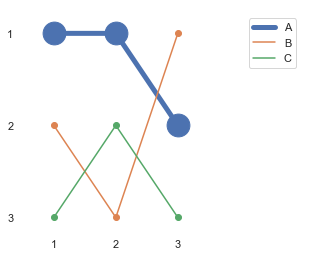

In [122]:
plt.figure(figsize=(5,4))
plt.plot([1,2,3], [1,1,2], label="A", linewidth=5)
plt.plot([1,2,3], [2,3,1], label="B")
plt.plot([1,2,3], [3,2,3], label="C")
plt.scatter([1,2,3], [1,1,2], s=520)
plt.scatter([1,2,3], [2,3,1])
plt.scatter([1,2,3], [3,2,3])
plt.yticks([1,2,3])
plt.gca().invert_yaxis()
sns.set_style("white")
plt.xlim((.5, 5))
sns.despine(left=True, bottom=True)
plt.legend(loc=0)
fig.tight_layout()
plt.xticks([1,2,3,4,5], [1,2,3,"",""])
plt.show()

In [163]:
list(df_word)

['Billy Zhao',
 'Timothy Lee',
 'Andrew Savage',
 'Jasmine Norng',
 'Yanis Ait Kaci Azzou',
 'Varsha Venkat',
 'Joan Hsu',
 'Jacob Holesinger',
 'Joshua Kang',
 'William Zhao',
 'Zermina Wadood',
 'Sasha Itkis',
 'James Ding',
 'Forest Yang',
 'Mulan Jane Xia',
 'Kathy Chen',
 'Isaac Chan',
 'Jane Lee',
 'Jingjing Zhang',
 'Yani Mai',
 'Sudeep Dasari',
 'Jerry Zhao',
 'Daniel A. Wang',
 'Sylvia Bi',
 'Joseph Mink Kwon',
 'Kevin Chu',
 'Megan Lee',
 'Tatiana Su',
 'Catherine Xu',
 'Yuna Shin',
 'Keiran Paster',
 'Thomas Chow',
 'Serena Jiang',
 'Deleted Users',
 'others']

## BUMP CHART STUFF (BETA)

In [30]:
new_df = df_word.drop(['others'], axis=1)

In [119]:

df = conv_to_perc(new_df)

ranking = df.values.argsort(axis=1)[24:,-5:]
names = list(df)
shape = np.shape(ranking)
ranking_names = np.reshape(np.array([names[x] for x in ranking.flatten()]), shape)

In [120]:
ind_rankings = {name:[np.nan]*len(ranking_names) for name in set(ranking_names.flatten())}
for date, rank in enumerate(ranking_names):
    for idx, name in enumerate(rank):
        ind_rankings[name][date] = idx

In [123]:
output_file("line.html")
x = [i for i in range(len(ranking_names))]
p = figure(plot_width=1800, plot_height=400)
for name, y in ind_rankings.items():
    color = COLOR_DICT[name]
    p.line(x, y, line_width=3, line_color=color)
    p.circle(x, y, radius=.25, fill_color=color, line_color=color)
show(p)